### Code Hist.

 - CODE  
    &ensp; : Crawling - 특일 정보 조회 (KASI)

  - DATE  
    &ensp; 2023-11-29 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1)   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2)    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   
    
 - DESC  
    &ensp; : 전처리 - 한국지역난방공사 열판매량/열공급량   
    &emsp; 1) 결측치가 없어서, 그대로 사용  
    &emsp;&ensp;&ensp; 
    &emsp;&ensp;&ensp; (Crawl Code 없음)   
    &emsp; 2) 

 - DATA  
    &emsp; <"Input">  
    1) None (Input Dataset)  
    &emsp;- Period :   
    &emsp;- Interval : 

    &emsp; <"Output">  
    1) Hourly (관측소/년도별 출력)  
    &nbsp;df_data_cal.to_csv(data_dir + 'KASI_DATE_D_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    2) Daily (관측소/년도별 출력)  
    &nbsp;df_data_cal_24.to_csv(data_dir + 'KASI_DATE_H_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['locdate', 'YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'HOUR', 'MINUTE']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    

 - Related Link  
    &ensp; : 

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [1]:
#region Basic_Import
## Basic
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
from pandas import DataFrame, Series

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

import glob
from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

## 정규화
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
## Modeling, Model Training
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
## Model 평가
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score   # model.score   

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [2]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [3]:
## Import_Local (현재 프로그램에서 미사용)
from DEV_Common_Data_Analysis import print_desc_statistic
from DEV_Common_Data_Datetime import create_col_ymdhm, create_col_datetime, create_df_dt, conv_midnight_24to00, create_col_weekdays #, validate_date, list_invalidDate, calc_df_dt
from DEV_Common_Data_Preprocessing import resample_by_last, find_outlier_Usages, del_outlier_Usages
from DEV_Common_Data_Visualization import visualization_df
from DEV_KASI_Holiday import KASI_holiDay, KASI_restDay, KASI_anniDay
from DEV_KMA_Weather_ASOS import KMA_ASOS_DATA
from DEV_KDHC_Usage import KDHC_HEAT_Usage

### 01-01-02. Config (Directory, Params)

In [4]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [5]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2024-01-02 09:03:50.965220
2024 / 1 / 2
9 : 3


## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage

In [29]:
# Define data root directory
str_dir_kdhcHeat = "./data_Energy_KDHC_National_Heat/"
print(os.listdir(str_dir_kdhcHeat))

df_kdhc_heat = pd.read_csv(str_dir_kdhcHeat + 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', index_col = 0)
df_kdhc_heat = df_kdhc_heat[['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'rest_YN', 'dist_from_holiday'
                             ,'HOUR'
                            #  , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
                            #  , 'humidity'
                            #  , 'rainfall'
                            #  , 'snowfall', 'snowfall_3hr'
                            #  , 'wind_speed', 'wind_direction'
                            #  , 'pressure_vapor', 'pressure_area', 'pressure_sea'
                            #  , 'visual_range'
                             , 'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG'
                             , 'KANGNAM'
                             , 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
                             , 'KIMHAE', 'DAEGU', 'YANGSAN'
                             , 'GWANGJU_JEONNAM']]
## 어디서 중복 생긴건지 확인 필요
df_kdhc_heat = df_kdhc_heat.drop_duplicates()
print(df_kdhc_heat.columns)
df_kdhc_heat

['KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv', 'KDHC_COMB_HEATSxPCA01_2019-2022_Scaled.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_complete_analysis.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_linearReg.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_mean_imp.csv', 'KDHC_COMB_HEAT_2019-2022.csv', 'KDHC_COMB_KANGNAMHEATxWEATHER_2019-2022.csv', 'KDHC_HEAT', 'KDHC_HEAT.zip', 'KDHC_HEAT_19Region_hr.csv', 'KDHC_HEAT_CHEONGJU_2010_2021.csv', 'KDHC_HEAT_CHEONGJU_2010_2021_1st_Check.csv', 'KDHC_HEAT_SEJONG_2014_2018.csv', 'KDHC_HEAT_SEJONG_2014_2018_1st_Check.csv', 'KDHC_NATIONAL_HEAT_hr.csv', 'KDHC_NATIONAL_HEAT_RAW_hr.csv']
Index(['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'rest_YN',
       'dist_from_holiday', 'HOUR', 'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG',
       'KANGNAM', 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON',
       'HWASUNG', 'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG', 'KIMHAE',
       'DAEGU', 'YANGSAN', 'GWANGJU_JEONNAM'],
   

,METER_DATE,YEAR,MONTH,DAY,code_day_of_the_week,rest_YN,dist_from_holiday,HOUR,PAJU,GOYANG,...,SUWON,HWASUNG,DONGTAN,PYONGTAEK,CHEONGJU,SEJONG,KIMHAE,DAEGU,YANGSAN,GWANGJU_JEONNAM
0,2019-10-01 01:00:00,2019,10,1,1,0,2,1,20,73.0000000000,...,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
2,2019-10-01 02:00:00,2019,10,1,1,0,2,2,15,65.0000000000,...,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
4,2019-10-01 03:00:00,2019,10,1,1,0,2,3,14,58.0000000000,...,33.0000000000,12.0000000000,14,0.5000000000,10,15.0000000000,7,15.0000000000,8,3
6,2019-10-01 04:00:00,2019,10,1,1,0,2,4,14,56.0000000000,...,38.0000000000,13.0000000000,18,0.5000000000,11,16.0000000000,6,13.0000000000,8,2
8,2019-10-01 05:00:00,2019,10,1,1,0,2,5,14,48.0000000000,...,42.0000000000,13.0000000000,15,0.5000000000,11,18.0000000000,6,13.0000000000,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27298,2022-09-30 20:00:00,2022,9,30,4,0,1,20,41,81.0000000000,...,73.0000000000,39.0000000000,61,12.0000000000,36,44.0000000000,12,30.0000000000,18,6
27299,2022-09-30 21:00:00,2022,9,30,4,0,1,21,40,90.0000000000,...,71.0000000000,36.0000000000,55,4.0000000000,30,44.0000000000,11,35.0000000000,22,5
27300,2022-09-30 22:00:00,2022,9,30,4,0,1,22,37,95.0000000000,...,65.0000000000,29.0000000000,45,2.0000000000,27,43.0000000000,12,32.0000000000,22,6
27301,2022-09-30 23:00:00,2022,9,30,4,0,1,23,32,98.0000000000,...,64.0000000000,25.0000000000,32,3.0000000000,25,40.0000000000,11,34.0000000000,22,6


In [31]:
# list_region = ['PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG'
#                , 'KANGNAM'
#                , 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
#                , 'KIMHAE', 'DAEGU', 'YANGSAN'
#                , 'GWANGJU_JEONNAM']



# ## 년도별
# for year in range(2019, 2022 + 1):
#     df_kdhc_heat_year = df_kdhc_heat[df_kdhc_heat['YEAR'] == year]

#     df_sum = pd.DataFrame()
#     df_tmp = pd.DataFrame()

#     ## 월별
#     for month in range(1, 12 + 1):
#         df_kdhc_heat_month = df_kdhc_heat_year[df_kdhc_heat_year['MONTH'] == month]
#         if len(df_kdhc_heat_month) == 0: continue

        

#         ## 요일별
#         for weekday in range(0, 6 + 1):
#             df_kdhc_heat_weekday = df_kdhc_heat_month[df_kdhc_heat_month['code_day_of_the_week'] == weekday]

#             ## 시간별
#             for hour in range(0, 23 + 1):
#                 df_kdhc_heat_hour = df_kdhc_heat_weekday[df_kdhc_heat_weekday['HOUR'] == hour]
#                 # print(df_kdhc_heat_hour)

#                 ## 지역별 합계
#                 for region in list_region:
#                     df_kdhc_heat_hour_region = df_kdhc_heat_hour[region].mean()

#                     ## tmp에 추가될 데이터 작성 및 sum에 병합
#                     df_tmp['YEAR'] = year
#                     df_tmp['MONTH'] = month
#                     df_tmp['CODE_DAY_OF_THE_WEEK'] = weekday
#                     df_tmp['HOUR'] = hour
#                     df_tmp[region] = df_kdhc_heat_hour_region

#                     df_sum = pd.concat([df_sum, df_tmp])
                    
# df_sum
# # df_kdhc_heat_month

In [50]:
list_region = ['PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG'
               , 'KANGNAM'
               , 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
               , 'KIMHAE', 'DAEGU', 'YANGSAN'
               , 'GWANGJU_JEONNAM']



year_tar = 2019
col_tar = 'PAJU'
df_sum = pd.DataFrame()
df_sum['YEAR'] = ''
df_sum['MONTH'] = ''
df_sum['CODE_DAY_OF_THE_WEEK'] = ''
df_sum['HOUR'] = ''
df_sum[col_tar] = ''
df_tmp = pd.DataFrame()
df_tmp['YEAR'] = ''
df_tmp['MONTH'] = ''
df_tmp['CODE_DAY_OF_THE_WEEK'] = ''
df_tmp['HOUR'] = ''
df_tmp[col_tar] = ''

## 년도별
df_kdhc_heat_year = df_kdhc_heat[df_kdhc_heat['YEAR'] == 2019]

## 월별
for month in range(1, 12 + 1):
    df_kdhc_heat_month = df_kdhc_heat_year[df_kdhc_heat_year['MONTH'] == month]
    if len(df_kdhc_heat_month) == 0: continue

    ## 요일별
    for weekday in range(0, 6 + 1):
        df_kdhc_heat_weekday = df_kdhc_heat_month[df_kdhc_heat_month['code_day_of_the_week'] == weekday]

        ## 시간별
        for hour in range(0, 23 + 1):
            df_kdhc_heat_hour = df_kdhc_heat_weekday[df_kdhc_heat_weekday['HOUR'] == hour]
            # print(df_kdhc_heat_hour)

            ## 지역별 합계
            df_kdhc_heat_hour_region = df_kdhc_heat_hour[['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'rest_YN', 'dist_from_holiday'
                                                          ,'HOUR'
                                                        #   , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
                                                        #   , 'humidity'
                                                        #   , 'rainfall'
                                                        #   , 'snowfall', 'snowfall_3hr'
                                                        #   , 'wind_speed', 'wind_direction'
                                                        #   , 'pressure_vapor', 'pressure_area', 'pressure_sea'
                                                        #   , 'visual_range'
                                                          , col_tar]]
            df_kdhc_heat_hour_region = df_kdhc_heat_hour[col_tar].mean()

            ## tmp에 추가될 데이터 작성 및 sum에 병합
            df_tmp.loc[0] = [str(year_tar), str(month), str(weekday), str(hour), str(df_kdhc_heat_hour_region)]
            print(df_tmp)

            df_sum = pd.concat([df_sum, df_tmp])
                
df_sum

   YEAR MONTH CODE_DAY_OF_THE_WEEK HOUR   PAJU
0  2019    10                    0    0  35.75
   YEAR MONTH CODE_DAY_OF_THE_WEEK HOUR   PAJU
0  2019    10                    0    1  28.25
   YEAR MONTH CODE_DAY_OF_THE_WEEK HOUR   PAJU
0  2019    10                    0    2  23.75
   YEAR MONTH CODE_DAY_OF_THE_WEEK HOUR  PAJU
0  2019    10                    0    3  23.0
   YEAR MONTH CODE_DAY_OF_THE_WEEK HOUR  PAJU
0  2019    10                    0    4  20.0
   YEAR MONTH CODE_DAY_OF_THE_WEEK HOUR  PAJU
0  2019    10                    0    5  20.0
   YEAR MONTH CODE_DAY_OF_THE_WEEK HOUR  PAJU
0  2019    10                    0    6  21.0
   YEAR MONTH CODE_DAY_OF_THE_WEEK HOUR  PAJU
0  2019    10                    0    7  29.0
   YEAR MONTH CODE_DAY_OF_THE_WEEK HOUR  PAJU
0  2019    10                    0    8  32.5
   YEAR MONTH CODE_DAY_OF_THE_WEEK HOUR  PAJU
0  2019    10                    0    9  29.0
   YEAR MONTH CODE_DAY_OF_THE_WEEK HOUR   PAJU
0  2019    10              

,YEAR,MONTH,CODE_DAY_OF_THE_WEEK,HOUR,PAJU
0,2019,10,0,0,35.75
0,2019,10,0,1,28.25
0,2019,10,0,2,23.75
0,2019,10,0,3,23.0
0,2019,10,0,4,20.0
...,...,...,...,...,...
0,2019,12,6,19,83.8
0,2019,12,6,20,91.4
0,2019,12,6,21,95.0
0,2019,12,6,22,103.4


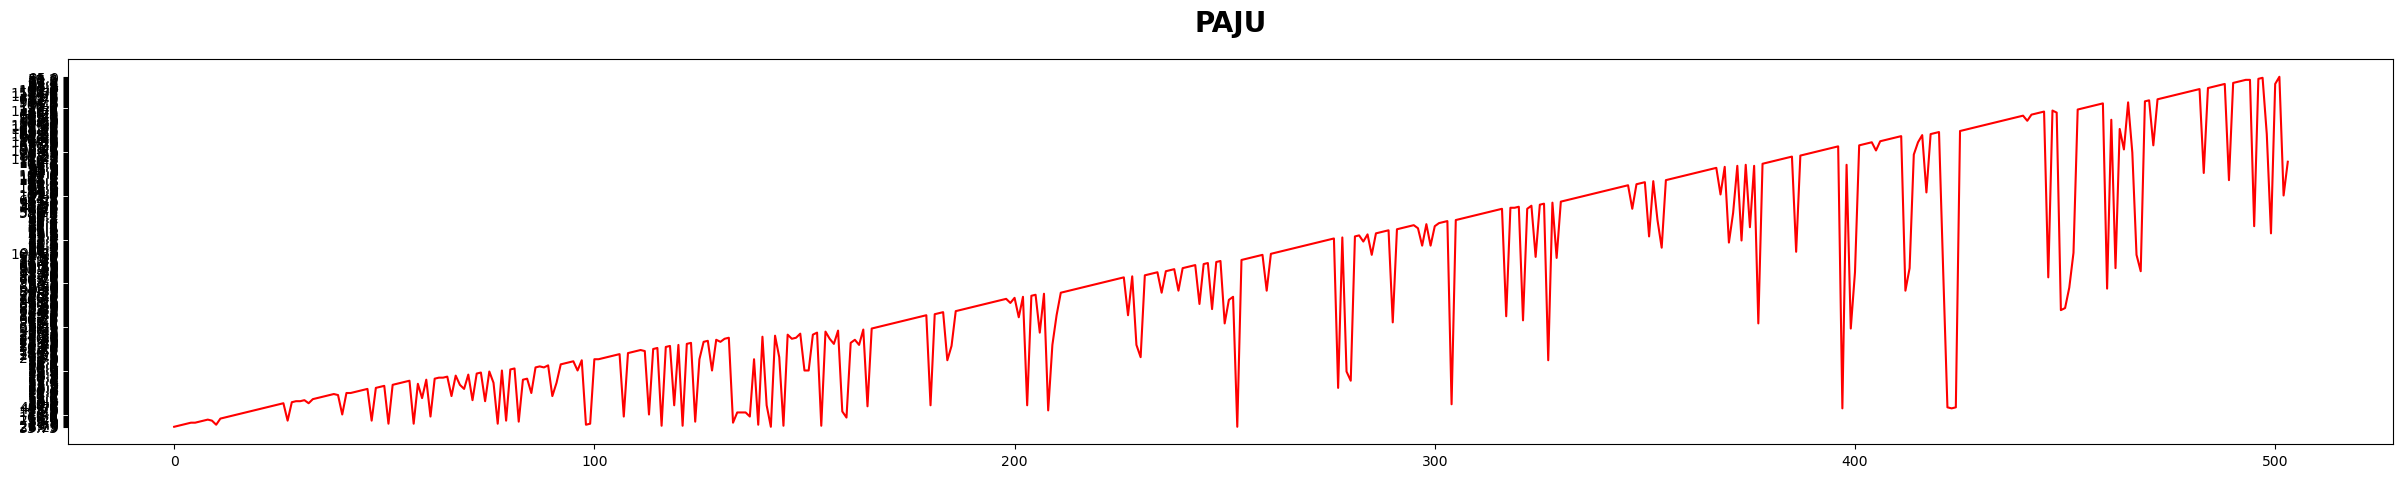

In [51]:
## 시각화
range_idx = range(0, len(df_sum))

fig, ax1 = plt.subplots(figsize=(30,5))
title_font = {'fontsize': 20, 'fontweight': 'bold'}

plt.title(col_tar, fontdict=title_font, loc='center', pad = 20)
ax1.plot(range_idx, df_sum[col_tar], color = 'red')

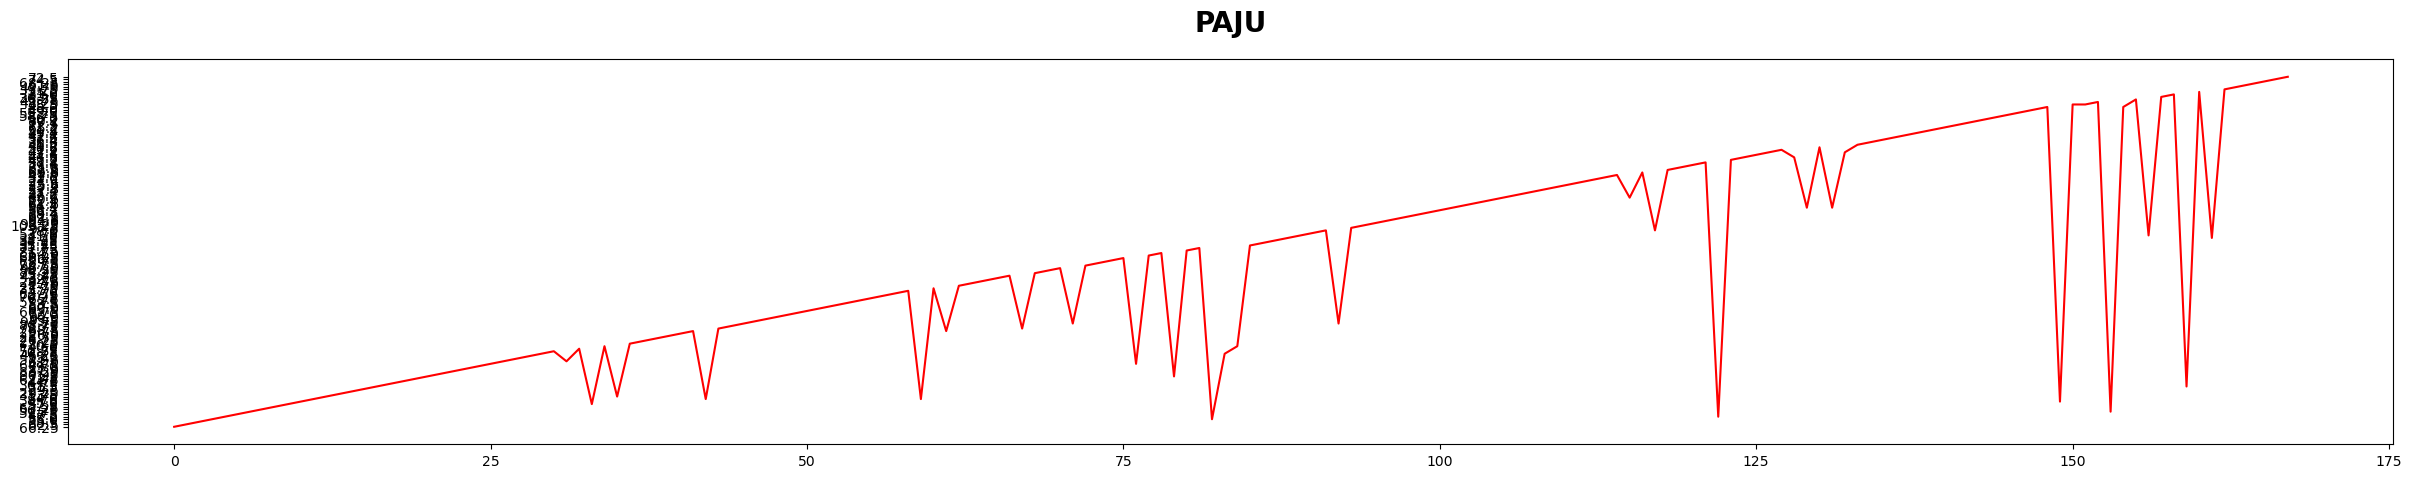

In [52]:
df_sum_monthly = df_sum[df_sum['MONTH'] == str(11)]

## 시각화
range_idx = range(0, len(df_sum_monthly))

fig, ax1 = plt.subplots(figsize=(30,5))
title_font = {'fontsize': 20, 'fontweight': 'bold'}

plt.title(col_tar, fontdict=title_font, loc='center', pad = 20)
ax1.plot(range_idx, df_sum_monthly[col_tar], color = 'red')

In [44]:
df_sum

,YEAR,MONTH,CODE_DAY_OF_THE_WEEK,HOUR,PAJU,METER_DATE
